In [1]:
# imports
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve

np.random.seed(1)

In [2]:
# data load, separate into predictors and labels for both train and test
train = pd.read_csv('../data/processed/train_proc.csv')
test = pd.read_csv('../data/processed/test_proc.csv')

train_X, train_labels = train.drop('status', axis=1), train['status']

test_X, test_labels = test.drop('status', axis=1), test['status']

In [3]:
# for scaling features
scaler = StandardScaler()
# define cross-validation procedure
k = 5
cv = KFold(n_splits=k, shuffle=True)

Logistic Regression

In [4]:
lr = LogisticRegression()

pipe = Pipeline(steps=[('scaler', scaler), ('model', lr)])

scores = cross_val_score(pipe, train_X, train_labels, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=False)
print(f'Average ROC AUC and std. across the folds: { np.round((scores.mean(), scores.std()), 3) }')

Average ROC AUC and std. across the folds: [0.763 0.006]


Neural Net

In [5]:
net = MLPClassifier(hidden_layer_sizes=(25), activation='relu', solver='adam', alpha=0.0001, batch_size=32, max_iter=250)

pipe_ = Pipeline(steps=[('scaler', scaler), ('model', net)])

scores_ = cross_val_score(pipe_, train_X, train_labels, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=False)
print(f'Average ROC AUC and std. across the folds: { np.round((scores_.mean(), scores_.std()), 3) }')

Average ROC AUC and std. across the folds: [0.773 0.006]


Let's fit the best model and test it

In [11]:
using_lr = True
clf = lr if using_lr else net
# using the standard scaler
train_X = scaler.fit_transform(train_X)
# cannot use fit_transform for test_X because it will cause overfitting
test_X = scaler.transform(test_X)
# fit the model to our training data
clf.fit(train_X, train_labels)
# save it!
mod = 'lr' if using_lr else 'net'
with open(f'../data/model/model_{mod}.pkl', 'wb') as f:
    pickle.dump(clf, f)
# predict probabilities of belonging to class for test data
preds_proba = clf.predict_proba(test_X)[:, 1]
# predict the binary class for test data
preds_bin = clf.predict(test_X)
# compute the ROC AUC curve based on our predictions
fpr, tpr, _ = roc_curve(y_true=test_labels, y_score=preds_proba)
# compute the actual ROC AUC score, too
auc = roc_auc_score(y_true=test_labels, y_score=preds_proba)
print(f'ROC AUC score: {round(auc, 3)}')

ROC AUC score: 0.741


In [7]:
# compute the accuracy score
acc = accuracy_score(y_true=test_labels, y_pred=preds_bin)
print(f'Accuracy: {round(acc, 3)}')

Accuracy: 0.681


In [8]:
# finally, showing the confusion matrix
conf_mtx = pd.DataFrame(confusion_matrix(y_true=test_labels, y_pred=preds_bin))
conf_mtx.index.name = 'True'
conf_mtx.columns.name = 'Predicted'

conf_mtx

Predicted,0,1
True,,
0,1527,778
1,815,1880


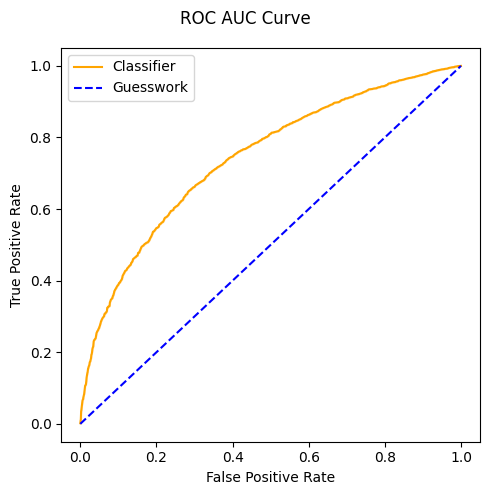

In [9]:
# plotting our ROC AUC curve. should be better than guesswork!
identity = np.linspace(0, 1, 100)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

sns.lineplot(x=fpr, y=tpr, c='orange', label='Classifier', ax=ax)
sns.lineplot(x=identity, y=identity, c='blue', label='Guesswork', linestyle='--', ax=ax)

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.suptitle('ROC AUC Curve')
plt.tight_layout()
plt.show()